In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
aug_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/augmented_testing_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [3]:

# Convert Timestamp columns to datetime (very important for time operations)
for df in [aug_train, aug_test, org_train, org_test]:
    df['Timestamp'] = pd.to_datetime(df['Time'])

In [4]:
# =========================
# Lag + Rolling Feature Engineering

def generate_lag_and_rolling_features(df, lags_dict, rolling_windows):
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Timestamp')  # time sort within location
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

# =========================
# Lag + Rolling Feature Engineering (Timestamp → AugType → Location sorting)

def generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows):
    df = df.copy()
    
    # First sort globally by Timestamp, AugmentationType, then Location
    df = df.sort_values(['Timestamp', 'augmented', 'Location']).reset_index(drop=True)
    
    all_groups = []
    
    # Group by (AugmentationType, Location) — after global sorting
    for (aug_type, loc), group in df.groupby(['augmented', 'Location']):
        group = group.sort_values('Timestamp')  # ensure strict time order within each subgroup
        
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged




def add_time_features(df):
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['month'] = df['Timestamp'].dt.month
    
    df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def scale_features(df, scaler=None, feature_cols=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[feature_cols])
    else:
        scaled_values = scaler.transform(df[feature_cols])

    df_scaled = df.copy()
    df_scaled[feature_cols] = scaled_values
    return df_scaled, scaler

In [5]:
# =========================
# Complete Pipeline Function

def full_preprocessing_pipeline(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

# =========================
# Complete Pipeline Function for augmented data

def full_preprocessing_pipeline_for_aug(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

In [6]:
# =========================
# Setup lags and rolling windows

lags_dict = {
    'Power': [1, 3, 6, 12, 24],
    'windspeed_10m': [1, 3, 6, 24],
    'windspeed_100m': [1, 3, 6, 24],
    'windgusts_10m': [1, 3, 6, 24],
}

rolling_windows = [3, 6, 12, 24]

# =========================
# Apply pipeline

# ORIGINAL DATA
org_train_processed, org_scaler = full_preprocessing_pipeline(org_train, lags_dict, rolling_windows)
org_test_processed, _           = full_preprocessing_pipeline(org_test, lags_dict, rolling_windows)

# AUGMENTED DATA
aug_train_processed, aug_scaler = full_preprocessing_pipeline_for_aug(aug_train, lags_dict, rolling_windows)
# aug_test_processed, _           = full_preprocessing_pipeline_for_aug(aug_test, lags_dict, rolling_windows)

print("All datasets processed successfully!")


All datasets processed successfully!


In [7]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power_lag1', 'Power_lag3',
       'Power_lag6', 'Power_lag12', 'Power_lag24', 'windspeed_10m_lag1',
       'windspeed_10m_lag3', 'windspeed_10m_lag6', 'windspeed_10m_lag24',
       'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
       'windspeed_100m_lag24', 'windgusts_10m_lag1', 'windgusts_10m_lag3',
       'windgusts_10m_lag6', 'windgusts_10m_lag24', 'Power_roll_mean_3',
       'Power_roll_std_3', 'windspeed_10m_roll_mean_3',
       'windspeed_10m_roll_std_3', 'windspeed_100m_roll_mean_3',
       'windspeed_100m_roll_std_3', 'windgusts_10m_roll_mean_3',
       'windgusts_10m_roll_std_3', 'Power_roll_mean_6', 'Power_roll_std_6',
       'windspeed_10m_roll_mean_6', 'windspeed_10m_roll_std_6',
       'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6',
       'windgusts_10m_roll_mean_6', 'windgusts_10m_roll_std_6',
       'Power_roll_mean_12', 'Power_roll_std_12', 'windspeed_10m_roll_mean_12',
       'windspeed_10m_roll_std_12', 'windspeed_100m_roll_mean_12',
       'windspeed_100m_roll_std_12', 'windgusts_10m_roll_mean_12',
       'windgusts_10m_roll_std_12', 'Power_roll_mean_24', 'Power_roll_std_24',
       'windspeed_10m_roll_mean_24', 'windspeed_10m_roll_std_24',
       'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24',
       'windgusts_10m_roll_mean_24', 'windgusts_10m_roll_std_24'
]
target = 'Power'

In [8]:
X_train_org = org_train_processed[features]
y_train_org = org_train_processed[target]
X_train_aug = aug_train_processed[features]
y_train_aug = aug_train_processed[target]

y_test  =org_test_processed[target]
X_test  =org_test_processed[features]

In [9]:
import torch
import torch.nn as nn
import numpy as np

# ------------------ TimesNet Model ------------------

class TimesBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), dilation=(1, dilation), padding=(0, dilation * (kernel_size - 1) // 2))
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.norm(out)
        out = self.relu(out)
        return out

class TimesNet(nn.Module):
    def __init__(self, input_len, forecast_len, num_features, hidden_channels=64, num_blocks=3, kernel_size=3):
        super().__init__()
        self.input_len = input_len
        self.forecast_len = forecast_len
        self.num_features = num_features

        self.blocks = nn.ModuleList()
        in_channels = 1

        for i in range(num_blocks):
            block = TimesBlock(in_channels, hidden_channels, kernel_size, dilation=2**i)
            self.blocks.append(block)
            in_channels = hidden_channels

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(hidden_channels, forecast_len)

    def forward(self, x):
        # Input shape: [Batch, Seq_len, Num_features]
        x = x.unsqueeze(1)  # [Batch, 1, Seq_len, Num_features] -> like an image
        for block in self.blocks:
            x = block(x)
        x = self.global_pool(x).squeeze(-1).squeeze(-1)
        out = self.fc(x)
        return out


In [10]:
# ------------------ Sequence Creation ------------------

def create_timesnet_multivariate_sequences(X_data, y_data, input_len, forecast_len):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - input_len - forecast_len + 1):
        X_seq.append(X_data[i:i+input_len])
        y_seq.append(y_data[i+input_len:i+input_len+forecast_len])
    return np.array(X_seq), np.array(y_seq)


In [11]:
import os
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

def train_timesnet_multivariate(X_train, y_train, input_len, forecast_len, epochs=10, batch_size=32, save_path="./timesnet_latest.pth"):
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

    num_features = X_train.shape[1]

    X_seq, y_seq = create_timesnet_multivariate_sequences(X_train_scaled, y_train_scaled, input_len, forecast_len)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    y_tensor = torch.tensor(y_seq, dtype=torch.float32)

    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = TimesNet(input_len=input_len, forecast_len=forecast_len, num_features=num_features)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    start_epoch = 0
    # -------- Load latest checkpoint if exists --------
    if os.path.exists(save_path):
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        start_epoch = checkpoint['epoch']
        print(f"Resumed training from epoch {start_epoch}")

    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0
        for xb, yb in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        # -------- Overwrite latest checkpoint --------
        torch.save({
            'epoch': epoch+1,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict()
        }, save_path)
        print(f"Checkpoint saved at epoch {epoch+1}: {save_path}")

    return model, scaler_X, scaler_y


In [12]:
# ------------------ Desequencing ------------------

def desequence_forecasts(predictions, input_len, forecast_len):
    total_length = len(predictions) + input_len + forecast_len - 1
    merged_forecast = np.zeros(total_length)
    count = np.zeros(total_length)

    for i in range(len(predictions)):
        start = i + input_len
        end = start + forecast_len
        merged_forecast[start:end] += predictions[i]
        count[start:end] += 1

    nonzero_mask = count != 0
    merged_forecast[nonzero_mask] /= count[nonzero_mask]
    return merged_forecast

# ------------------ Evaluation ------------------

import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_timesnet_multivariate(model, scaler_X, scaler_y, X_test, y_test, input_len, forecast_len, time_index=None, start_point=0, end_point=None):
    X_test = X_test[start_point:end_point]
    y_test = y_test[start_point:end_point]

    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    X_seq, y_seq = create_timesnet_multivariate_sequences(X_test_scaled, y_test_scaled, input_len, forecast_len)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        preds_scaled = model(X_tensor).numpy()

    preds = scaler_y.inverse_transform(preds_scaled.reshape(-1, 1)).reshape(preds_scaled.shape)
    y_true = scaler_y.inverse_transform(y_seq.reshape(-1, 1)).reshape(y_seq.shape)

    merged_pred = desequence_forecasts(preds, input_len, forecast_len)
    merged_true = desequence_forecasts(y_true, input_len, forecast_len)

    merged_pred = merged_pred
    merged_true = merged_true

    mse = mean_squared_error(merged_true, merged_pred)
    mae = mean_absolute_error(merged_true, merged_pred)
    rmse = math.sqrt(mse)
    print(f"Test MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    if time_index is not None:
        valid_time_index = time_index[input_len+forecast_len:][:len(merged_pred)]
    else:
        valid_time_index = range(len(merged_pred))

    plt.figure(figsize=(16, 6))
    plt.plot(valid_time_index, merged_true, label="Actual", color="black")
    plt.plot(valid_time_index, merged_pred, label="Forecast", color="red", linestyle="--")
    plt.xlabel("Time" if time_index is not None else "Steps")
    plt.ylabel("Power")
    plt.title("TimesNet Forecast vs Actual")
    plt.legend()
    plt.grid(True)
    textstr = f'MAE: {mae:.4f}\nRMSE: {rmse:.4f}'
    plt.gcf().text(0.75, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()


In [13]:
X_train_org = org_train_processed[features].values
y_train_org = org_train_processed[target].values

X_train_aug = aug_train_processed[features].values
y_train_aug = aug_train_processed[target].values

X_test = org_test_processed[features].values
y_test = org_test_processed[target].values

input_len = 24
forecast_len = 12


In [15]:
# Train
print("Training TimesNet...")
model_timesnet, scaler_X_timesnet, scaler_y_timesnet = train_timesnet_multivariate(X_train_org, y_train_org, input_len, forecast_len, epochs=40, save_path="../weights/timesnet_org_shuffle.pth")


Training TimesNet...
Resumed training from epoch 10


Epoch 11: 100%|██████████| 4377/4377 [05:11<00:00, 14.07it/s]


Epoch 11, Loss: 0.4525
Checkpoint saved at epoch 11: ../weights/timesnet_org_shuffle.pth


Epoch 12: 100%|██████████| 4377/4377 [05:10<00:00, 14.12it/s]


Epoch 12, Loss: 0.4433
Checkpoint saved at epoch 12: ../weights/timesnet_org_shuffle.pth


Epoch 13: 100%|██████████| 4377/4377 [05:11<00:00, 14.06it/s]


Epoch 13, Loss: 0.4369
Checkpoint saved at epoch 13: ../weights/timesnet_org_shuffle.pth


Epoch 14: 100%|██████████| 4377/4377 [05:10<00:00, 14.09it/s]


Epoch 14, Loss: 0.4288
Checkpoint saved at epoch 14: ../weights/timesnet_org_shuffle.pth


Epoch 15: 100%|██████████| 4377/4377 [05:11<00:00, 14.06it/s]


Epoch 15, Loss: 0.4218
Checkpoint saved at epoch 15: ../weights/timesnet_org_shuffle.pth


Epoch 16: 100%|██████████| 4377/4377 [05:10<00:00, 14.09it/s]


Epoch 16, Loss: 0.4145
Checkpoint saved at epoch 16: ../weights/timesnet_org_shuffle.pth


Epoch 17: 100%|██████████| 4377/4377 [05:11<00:00, 14.07it/s]


Epoch 17, Loss: 0.4089
Checkpoint saved at epoch 17: ../weights/timesnet_org_shuffle.pth


Epoch 18: 100%|██████████| 4377/4377 [05:11<00:00, 14.05it/s]


Epoch 18, Loss: 0.4035
Checkpoint saved at epoch 18: ../weights/timesnet_org_shuffle.pth


Epoch 19: 100%|██████████| 4377/4377 [05:11<00:00, 14.06it/s]


Epoch 19, Loss: 0.3974
Checkpoint saved at epoch 19: ../weights/timesnet_org_shuffle.pth


Epoch 20: 100%|██████████| 4377/4377 [05:10<00:00, 14.09it/s]


Epoch 20, Loss: 0.3930
Checkpoint saved at epoch 20: ../weights/timesnet_org_shuffle.pth


Epoch 21: 100%|██████████| 4377/4377 [05:10<00:00, 14.08it/s]


Epoch 21, Loss: 0.3874
Checkpoint saved at epoch 21: ../weights/timesnet_org_shuffle.pth


Epoch 22: 100%|██████████| 4377/4377 [05:11<00:00, 14.05it/s]


Epoch 22, Loss: 0.3829
Checkpoint saved at epoch 22: ../weights/timesnet_org_shuffle.pth


Epoch 23: 100%|██████████| 4377/4377 [05:11<00:00, 14.07it/s]


Epoch 23, Loss: 0.3777
Checkpoint saved at epoch 23: ../weights/timesnet_org_shuffle.pth


Epoch 24: 100%|██████████| 4377/4377 [05:09<00:00, 14.13it/s]


Epoch 24, Loss: 0.3754
Checkpoint saved at epoch 24: ../weights/timesnet_org_shuffle.pth


Epoch 25: 100%|██████████| 4377/4377 [05:09<00:00, 14.15it/s]


Epoch 25, Loss: 0.3713
Checkpoint saved at epoch 25: ../weights/timesnet_org_shuffle.pth


Epoch 26: 100%|██████████| 4377/4377 [05:09<00:00, 14.15it/s]


Epoch 26, Loss: 0.3655
Checkpoint saved at epoch 26: ../weights/timesnet_org_shuffle.pth


Epoch 27: 100%|██████████| 4377/4377 [05:09<00:00, 14.16it/s]


Epoch 27, Loss: 0.3630
Checkpoint saved at epoch 27: ../weights/timesnet_org_shuffle.pth


Epoch 28: 100%|██████████| 4377/4377 [05:09<00:00, 14.16it/s]


Epoch 28, Loss: 0.3580
Checkpoint saved at epoch 28: ../weights/timesnet_org_shuffle.pth


Epoch 29: 100%|██████████| 4377/4377 [05:09<00:00, 14.15it/s]


Epoch 29, Loss: 0.3551
Checkpoint saved at epoch 29: ../weights/timesnet_org_shuffle.pth


Epoch 30: 100%|██████████| 4377/4377 [05:11<00:00, 14.07it/s]


Epoch 30, Loss: 0.3517
Checkpoint saved at epoch 30: ../weights/timesnet_org_shuffle.pth


Epoch 31: 100%|██████████| 4377/4377 [05:09<00:00, 14.14it/s]


Epoch 31, Loss: 0.3481
Checkpoint saved at epoch 31: ../weights/timesnet_org_shuffle.pth


Epoch 32: 100%|██████████| 4377/4377 [05:09<00:00, 14.14it/s]


Epoch 32, Loss: 0.3440
Checkpoint saved at epoch 32: ../weights/timesnet_org_shuffle.pth


Epoch 33: 100%|██████████| 4377/4377 [05:09<00:00, 14.14it/s]


Epoch 33, Loss: 0.3418
Checkpoint saved at epoch 33: ../weights/timesnet_org_shuffle.pth


Epoch 34: 100%|██████████| 4377/4377 [05:09<00:00, 14.12it/s]


Epoch 34, Loss: 0.3373
Checkpoint saved at epoch 34: ../weights/timesnet_org_shuffle.pth


Epoch 35: 100%|██████████| 4377/4377 [05:09<00:00, 14.14it/s]


Epoch 35, Loss: 0.3359
Checkpoint saved at epoch 35: ../weights/timesnet_org_shuffle.pth


Epoch 36: 100%|██████████| 4377/4377 [05:09<00:00, 14.13it/s]


Epoch 36, Loss: 0.3323
Checkpoint saved at epoch 36: ../weights/timesnet_org_shuffle.pth


Epoch 37: 100%|██████████| 4377/4377 [05:10<00:00, 14.10it/s]


Epoch 37, Loss: 0.3289
Checkpoint saved at epoch 37: ../weights/timesnet_org_shuffle.pth


Epoch 38: 100%|██████████| 4377/4377 [05:09<00:00, 14.15it/s]


Epoch 38, Loss: 0.3279
Checkpoint saved at epoch 38: ../weights/timesnet_org_shuffle.pth


Epoch 39: 100%|██████████| 4377/4377 [05:09<00:00, 14.15it/s]


Epoch 39, Loss: 0.3235
Checkpoint saved at epoch 39: ../weights/timesnet_org_shuffle.pth


Epoch 40: 100%|██████████| 4377/4377 [05:08<00:00, 14.17it/s]


Epoch 40, Loss: 0.3227
Checkpoint saved at epoch 40: ../weights/timesnet_org_shuffle.pth


In [14]:
# Train
print("Training TimesNet...")
model_timesnet_aug, scaler_X_timesne_aug, scaler_y_timesnet_aug = train_timesnet_multivariate(X_train_aug, y_train_aug, input_len, forecast_len, epochs=40,  save_path="../weights/timesnet_aug_shuffle.pth")

Training TimesNet...
Resumed training from epoch 10


Epoch 11: 100%|██████████| 26262/26262 [32:58<00:00, 13.27it/s]


Epoch 11, Loss: 0.3192
Checkpoint saved at epoch 11: ../weights/timesnet_aug_shuffle.pth


Epoch 12: 100%|██████████| 26262/26262 [32:02<00:00, 13.66it/s]


Epoch 12, Loss: 0.3120
Checkpoint saved at epoch 12: ../weights/timesnet_aug_shuffle.pth


Epoch 13: 100%|██████████| 26262/26262 [32:07<00:00, 13.62it/s]


Epoch 13, Loss: 0.3049
Checkpoint saved at epoch 13: ../weights/timesnet_aug_shuffle.pth


Epoch 14: 100%|██████████| 26262/26262 [32:17<00:00, 13.55it/s]


Epoch 14, Loss: 0.2995
Checkpoint saved at epoch 14: ../weights/timesnet_aug_shuffle.pth


Epoch 15: 100%|██████████| 26262/26262 [32:28<00:00, 13.48it/s]


Epoch 15, Loss: 0.2938
Checkpoint saved at epoch 15: ../weights/timesnet_aug_shuffle.pth


Epoch 16: 100%|██████████| 26262/26262 [32:08<00:00, 13.61it/s]


Epoch 16, Loss: 0.2888
Checkpoint saved at epoch 16: ../weights/timesnet_aug_shuffle.pth


Epoch 17: 100%|██████████| 26262/26262 [32:19<00:00, 13.54it/s]


Epoch 17, Loss: 0.2841
Checkpoint saved at epoch 17: ../weights/timesnet_aug_shuffle.pth


Epoch 18: 100%|██████████| 26262/26262 [32:18<00:00, 13.55it/s]


Epoch 18, Loss: 0.2800
Checkpoint saved at epoch 18: ../weights/timesnet_aug_shuffle.pth


Epoch 19: 100%|██████████| 26262/26262 [37:52<00:00, 11.56it/s]


Epoch 19, Loss: 0.2763
Checkpoint saved at epoch 19: ../weights/timesnet_aug_shuffle.pth


Epoch 20: 100%|██████████| 26262/26262 [33:23<00:00, 13.10it/s]


Epoch 20, Loss: 0.2730
Checkpoint saved at epoch 20: ../weights/timesnet_aug_shuffle.pth


Epoch 21: 100%|██████████| 26262/26262 [32:07<00:00, 13.63it/s]


Epoch 21, Loss: 0.2696
Checkpoint saved at epoch 21: ../weights/timesnet_aug_shuffle.pth


Epoch 22: 100%|██████████| 26262/26262 [34:35<00:00, 12.65it/s]


Epoch 22, Loss: 0.2666
Checkpoint saved at epoch 22: ../weights/timesnet_aug_shuffle.pth


Epoch 23: 100%|██████████| 26262/26262 [33:02<00:00, 13.25it/s]


Epoch 23, Loss: 0.2631
Checkpoint saved at epoch 23: ../weights/timesnet_aug_shuffle.pth


Epoch 24: 100%|██████████| 26262/26262 [32:04<00:00, 13.65it/s]


Epoch 24, Loss: 0.2602
Checkpoint saved at epoch 24: ../weights/timesnet_aug_shuffle.pth


Epoch 25: 100%|██████████| 26262/26262 [32:00<00:00, 13.68it/s]


Epoch 25, Loss: 0.2581
Checkpoint saved at epoch 25: ../weights/timesnet_aug_shuffle.pth


Epoch 26: 100%|██████████| 26262/26262 [32:09<00:00, 13.61it/s]


Epoch 26, Loss: 0.2559
Checkpoint saved at epoch 26: ../weights/timesnet_aug_shuffle.pth


Epoch 27: 100%|██████████| 26262/26262 [32:14<00:00, 13.57it/s]


Epoch 27, Loss: 0.2531
Checkpoint saved at epoch 27: ../weights/timesnet_aug_shuffle.pth


Epoch 28: 100%|██████████| 26262/26262 [32:18<00:00, 13.55it/s]


Epoch 28, Loss: 0.2505
Checkpoint saved at epoch 28: ../weights/timesnet_aug_shuffle.pth


Epoch 29: 100%|██████████| 26262/26262 [32:16<00:00, 13.56it/s]


Epoch 29, Loss: 0.2484
Checkpoint saved at epoch 29: ../weights/timesnet_aug_shuffle.pth


Epoch 30: 100%|██████████| 26262/26262 [32:09<00:00, 13.61it/s]


Epoch 30, Loss: 0.2468
Checkpoint saved at epoch 30: ../weights/timesnet_aug_shuffle.pth


Epoch 31: 100%|██████████| 26262/26262 [32:16<00:00, 13.56it/s]


Epoch 31, Loss: 0.2448
Checkpoint saved at epoch 31: ../weights/timesnet_aug_shuffle.pth


Epoch 32: 100%|██████████| 26262/26262 [32:00<00:00, 13.67it/s]


Epoch 32, Loss: 0.2430
Checkpoint saved at epoch 32: ../weights/timesnet_aug_shuffle.pth


Epoch 33: 100%|██████████| 26262/26262 [32:21<00:00, 13.53it/s]


Epoch 33, Loss: 0.2410
Checkpoint saved at epoch 33: ../weights/timesnet_aug_shuffle.pth


Epoch 34: 100%|██████████| 26262/26262 [32:06<00:00, 13.63it/s]


Epoch 34, Loss: 0.2396
Checkpoint saved at epoch 34: ../weights/timesnet_aug_shuffle.pth


Epoch 35: 100%|██████████| 26262/26262 [32:07<00:00, 13.63it/s]


Epoch 35, Loss: 0.2382
Checkpoint saved at epoch 35: ../weights/timesnet_aug_shuffle.pth


Epoch 36: 100%|██████████| 26262/26262 [32:06<00:00, 13.63it/s]


Epoch 36, Loss: 0.2370
Checkpoint saved at epoch 36: ../weights/timesnet_aug_shuffle.pth


Epoch 37: 100%|██████████| 26262/26262 [31:57<00:00, 13.70it/s]


Epoch 37, Loss: 0.2353
Checkpoint saved at epoch 37: ../weights/timesnet_aug_shuffle.pth


Epoch 38: 100%|██████████| 26262/26262 [32:10<00:00, 13.60it/s]


Epoch 38, Loss: 0.2341
Checkpoint saved at epoch 38: ../weights/timesnet_aug_shuffle.pth


Epoch 39: 100%|██████████| 26262/26262 [31:50<00:00, 13.75it/s]


Epoch 39, Loss: 0.2326
Checkpoint saved at epoch 39: ../weights/timesnet_aug_shuffle.pth


Epoch 40: 100%|██████████| 26262/26262 [32:47<00:00, 13.35it/s]


Epoch 40, Loss: 0.2309
Checkpoint saved at epoch 40: ../weights/timesnet_aug_shuffle.pth



Evaluating TimesNet...
Test MSE: 0.0559, MAE: 0.1935, RMSE: 0.2364


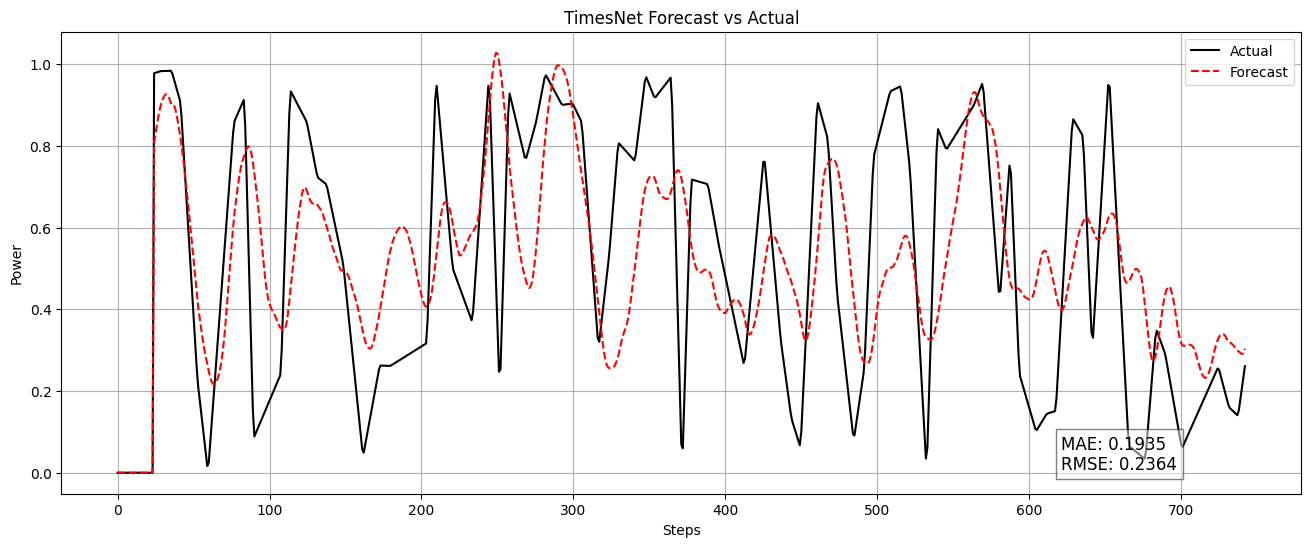

Test MSE: 0.0294, MAE: 0.1378, RMSE: 0.1715


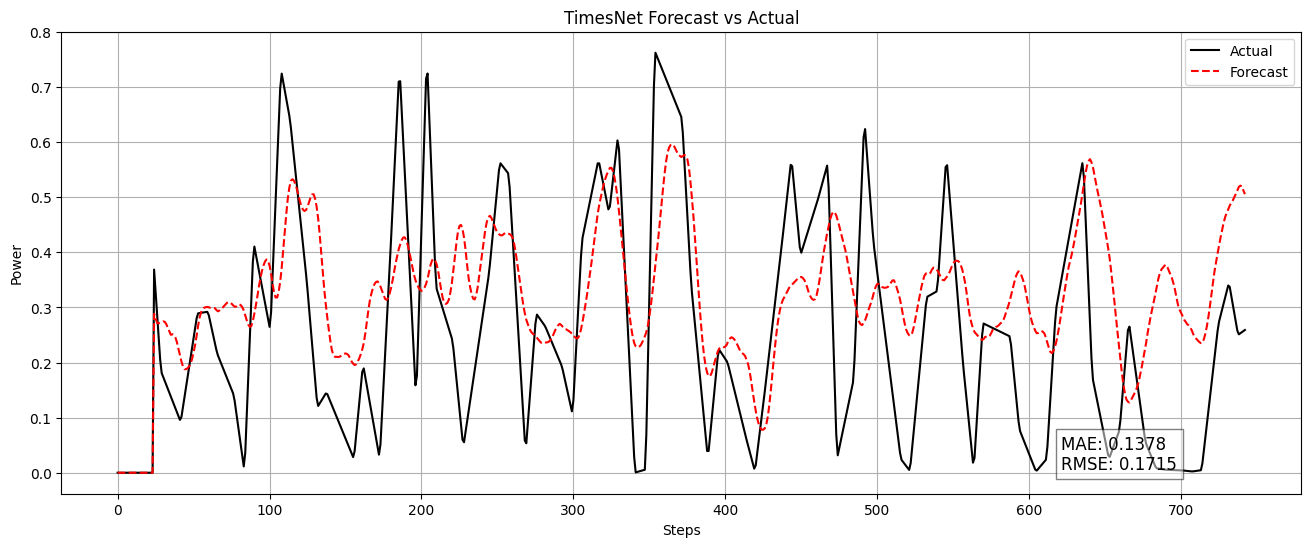

Test MSE: 0.0724, MAE: 0.2159, RMSE: 0.2690


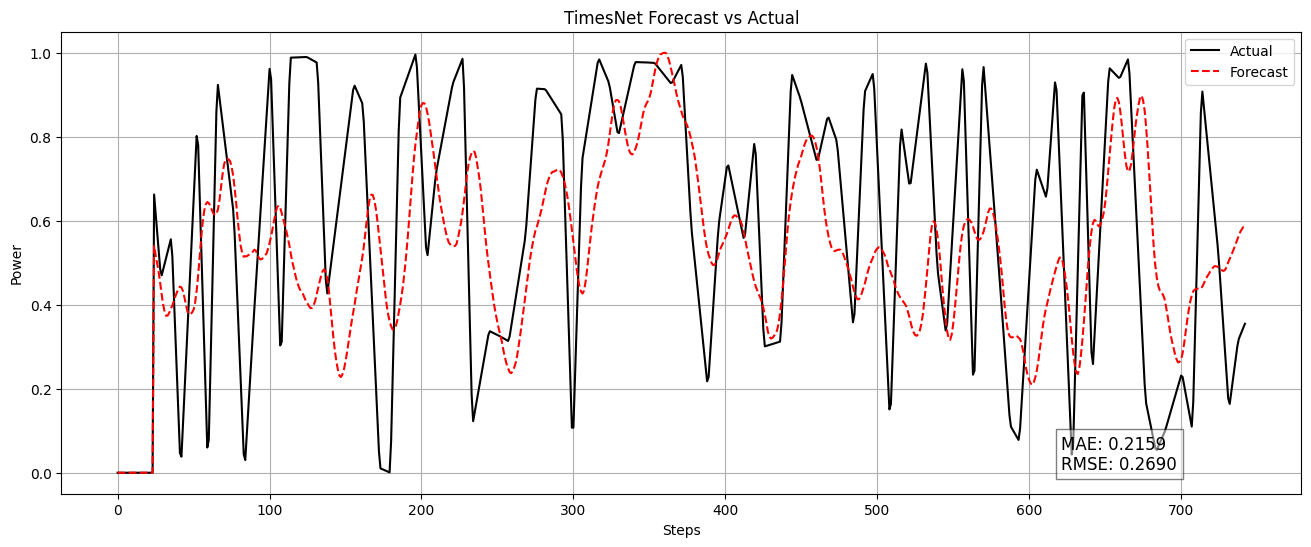

Test MSE: 0.0534, MAE: 0.1892, RMSE: 0.2311


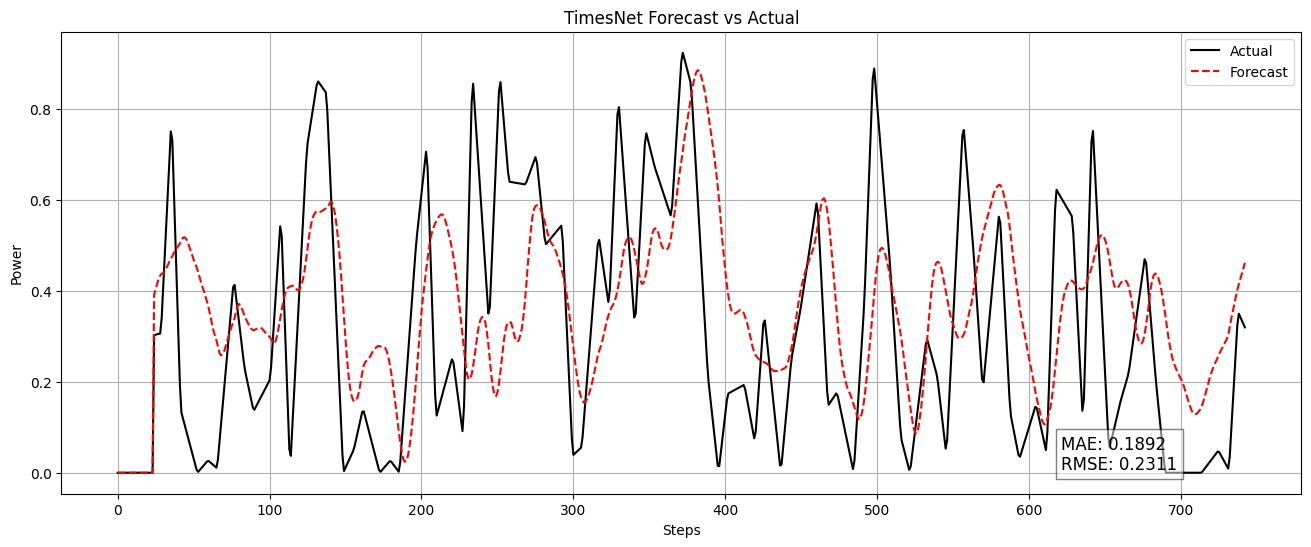

In [15]:
# Evaluate
print("\nEvaluating TimesNet...")
evaluate_timesnet_multivariate(model_timesnet_aug, scaler_X_timesne_aug, scaler_y_timesnet_aug, X_test, y_test, input_len, forecast_len, start_point=7991, end_point=8734)
evaluate_timesnet_multivariate(model_timesnet_aug, scaler_X_timesne_aug, scaler_y_timesnet_aug, X_test, y_test, input_len, forecast_len, start_point=16726, end_point=17469)
evaluate_timesnet_multivariate(model_timesnet_aug, scaler_X_timesne_aug, scaler_y_timesnet_aug, X_test, y_test, input_len, forecast_len, start_point=25461, end_point=26204)
evaluate_timesnet_multivariate(model_timesnet_aug, scaler_X_timesne_aug, scaler_y_timesnet_aug, X_test, y_test, input_len, forecast_len, start_point=34196, end_point=34939)



Evaluating TimesNet...
Test MSE: 0.0585, MAE: 0.2079, RMSE: 0.2419


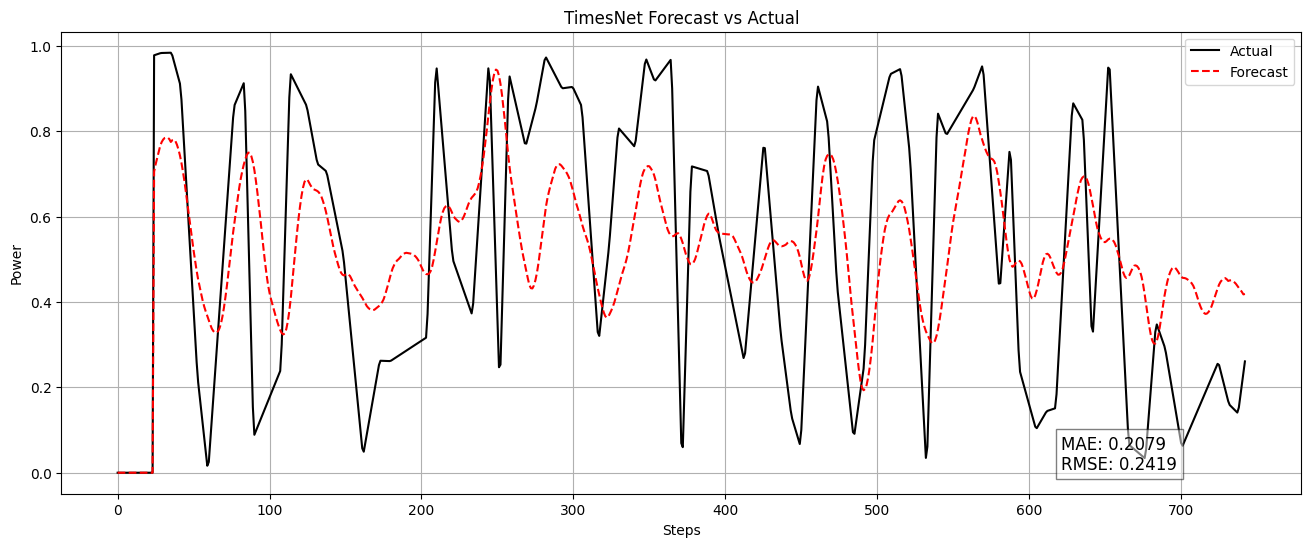

Test MSE: 0.0407, MAE: 0.1634, RMSE: 0.2018


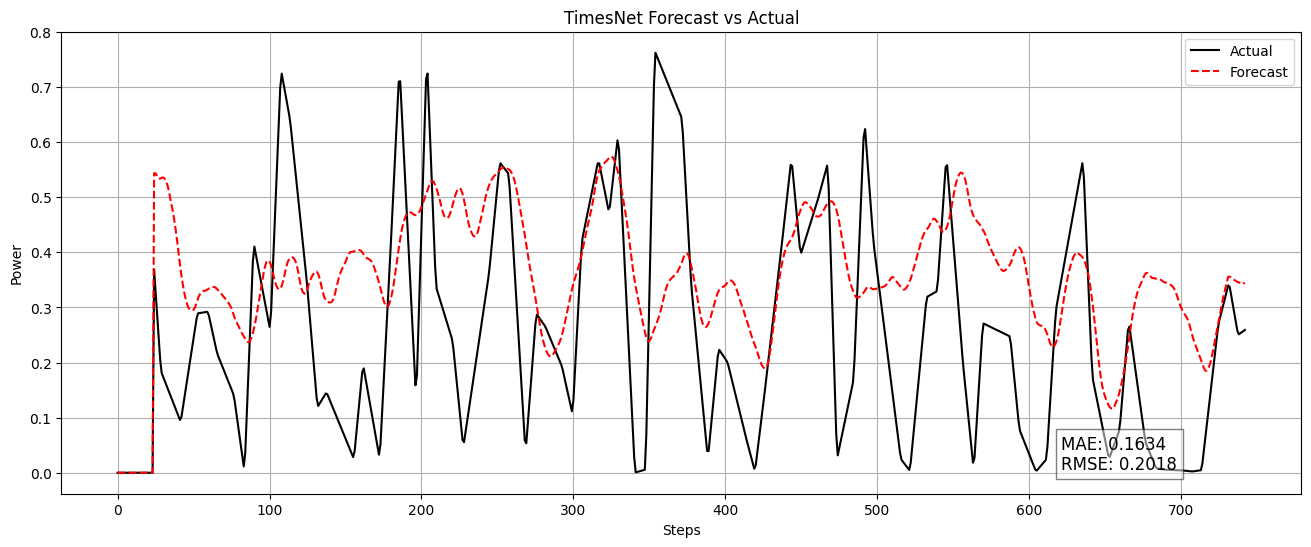

Test MSE: 0.0728, MAE: 0.2270, RMSE: 0.2698


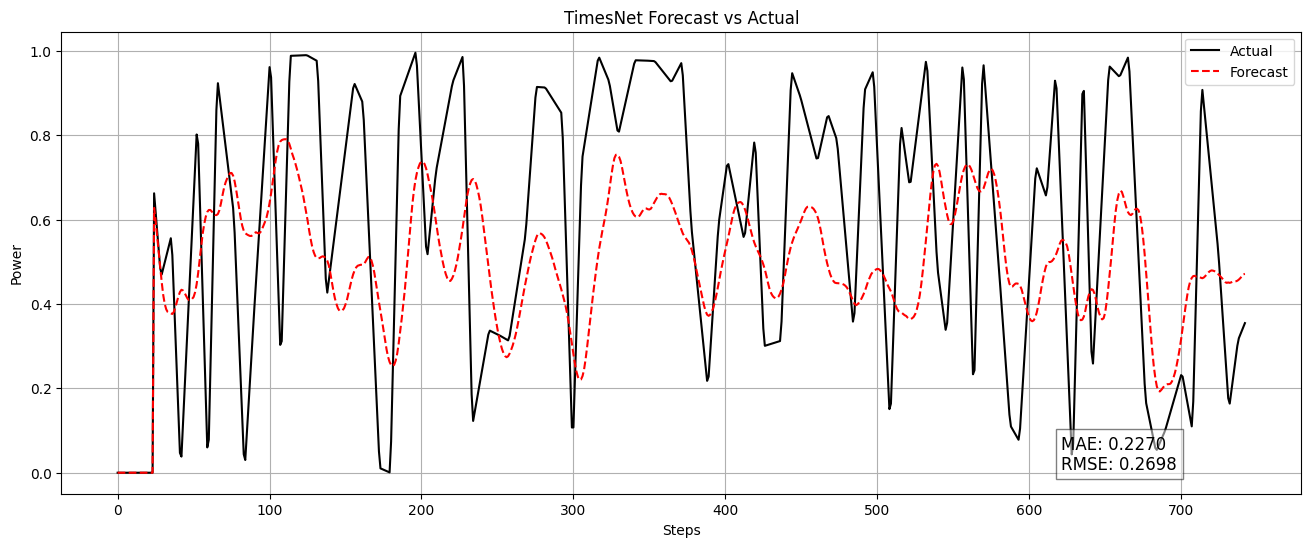

Test MSE: 0.0514, MAE: 0.1931, RMSE: 0.2268


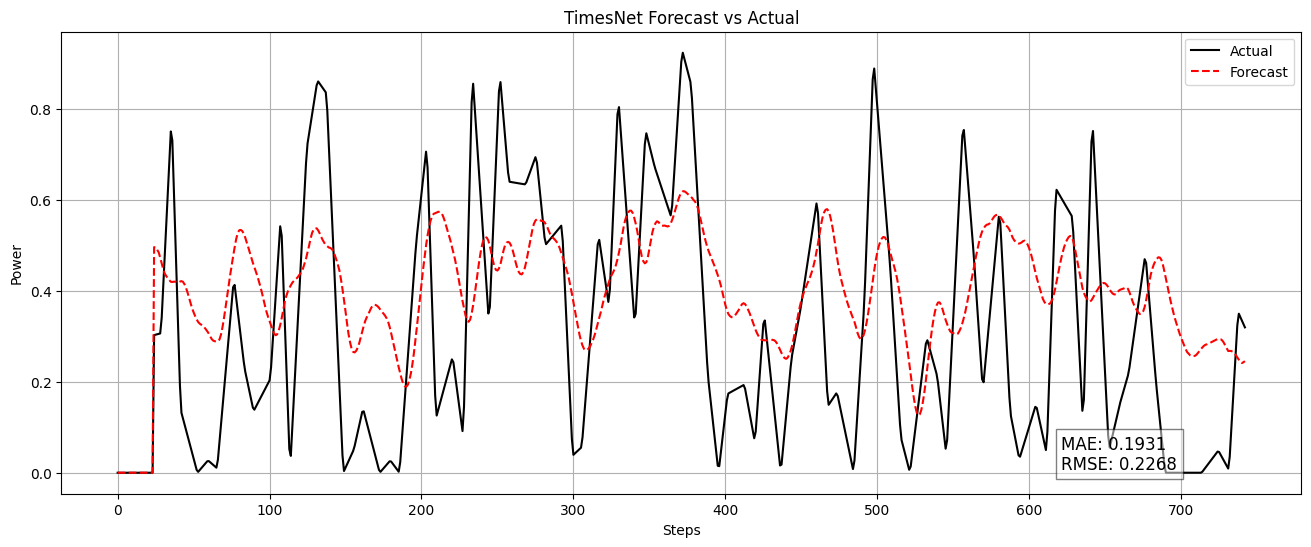

In [28]:
# Evaluate
print("\nEvaluating TimesNet...")
evaluate_timesnet_multivariate(model_timesnet, scaler_X_timesnet, scaler_y_timesnet, X_test, y_test, input_len, forecast_len, start_point=7991, end_point=8734)
evaluate_timesnet_multivariate(model_timesnet, scaler_X_timesnet, scaler_y_timesnet, X_test, y_test, input_len, forecast_len, start_point=16726, end_point=17469)
evaluate_timesnet_multivariate(model_timesnet, scaler_X_timesnet, scaler_y_timesnet, X_test, y_test, input_len, forecast_len, start_point=25461, end_point=26204)
evaluate_timesnet_multivariate(model_timesnet, scaler_X_timesnet, scaler_y_timesnet, X_test, y_test, input_len, forecast_len, start_point=34196, end_point=34939)


In [18]:
num_features = X_test.shape[1]
model = TimesNet(input_len=input_len, forecast_len=forecast_len, num_features=num_features)


In [19]:
checkpoint = torch.load('../weights/timesnet_aug.pth')
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>


Evaluating TimesNet...
Test MSE: 0.1338, MAE: 0.2951, RMSE: 0.3658


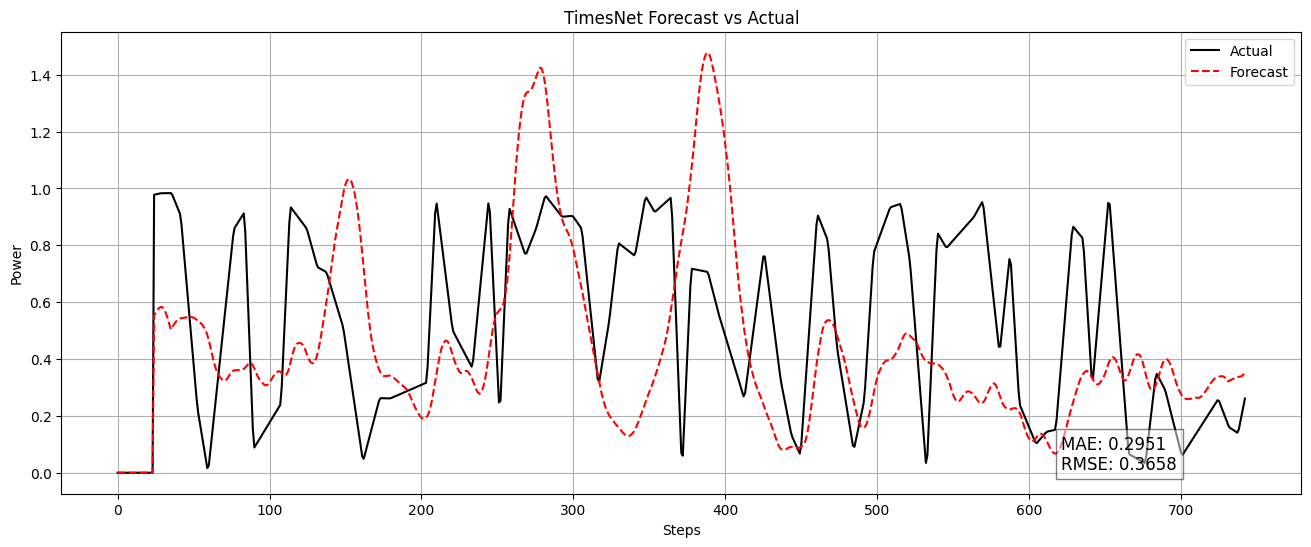

Test MSE: 0.1356, MAE: 0.2761, RMSE: 0.3682


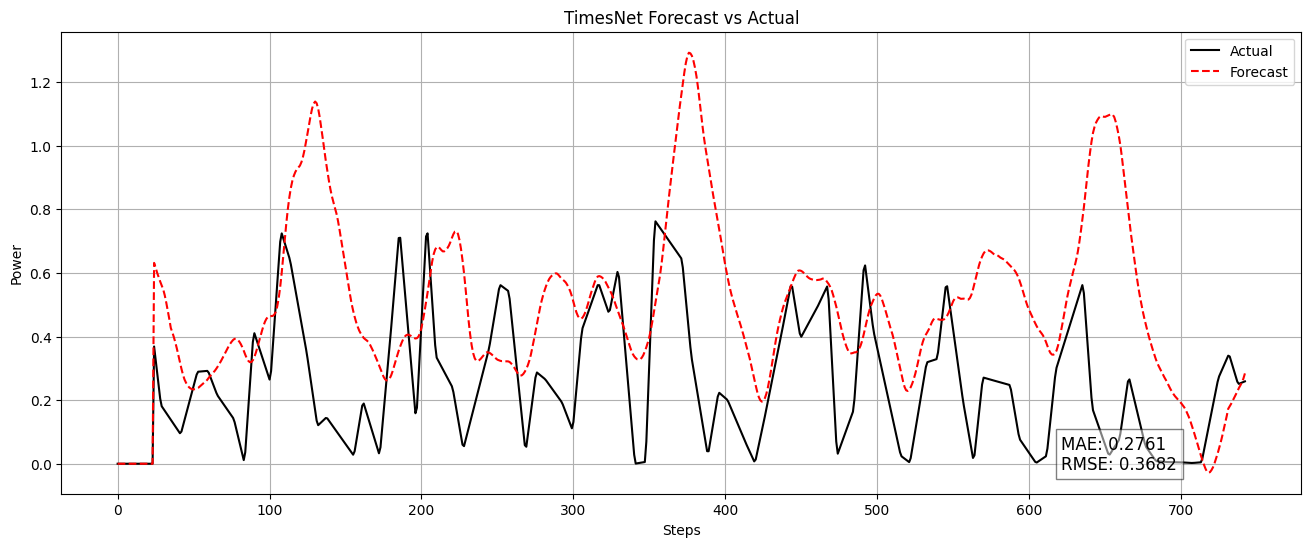

Test MSE: 0.2166, MAE: 0.3417, RMSE: 0.4654


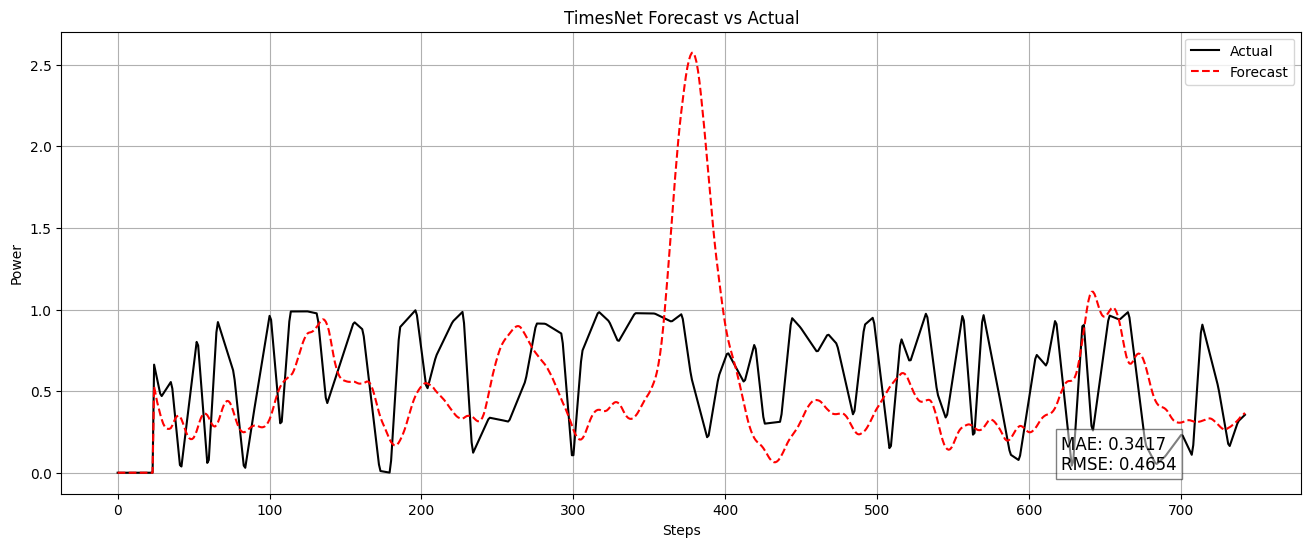

Test MSE: 0.1464, MAE: 0.2472, RMSE: 0.3826


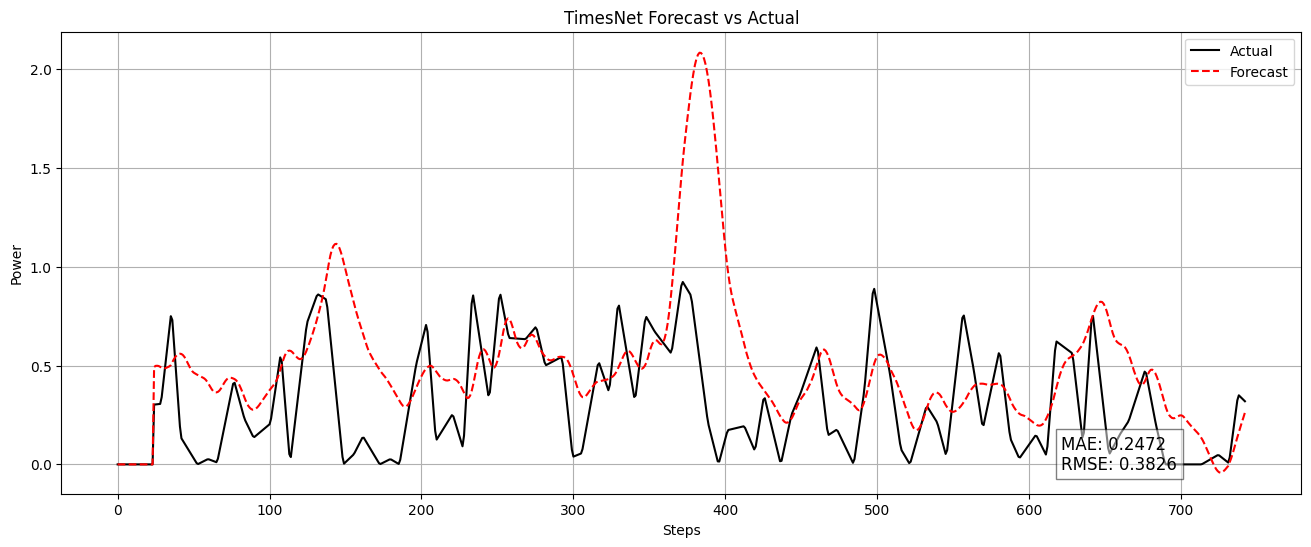

In [25]:
# Evaluate
print("\nEvaluating TimesNet...")

evaluate_timesnet_multivariate(model, scaler_X_timesnet, scaler_y_timesnet, X_test, y_test, input_len, forecast_len, start_point=7991, end_point=8734)
evaluate_timesnet_multivariate(model, scaler_X_timesnet, scaler_y_timesnet, X_test, y_test, input_len, forecast_len, start_point=16726, end_point=17469)
evaluate_timesnet_multivariate(model, scaler_X_timesnet, scaler_y_timesnet, X_test, y_test, input_len, forecast_len, start_point=25461, end_point=26204)
evaluate_timesnet_multivariate(model, scaler_X_timesnet, scaler_y_timesnet, X_test, y_test, input_len, forecast_len, start_point=34196, end_point=34939)
